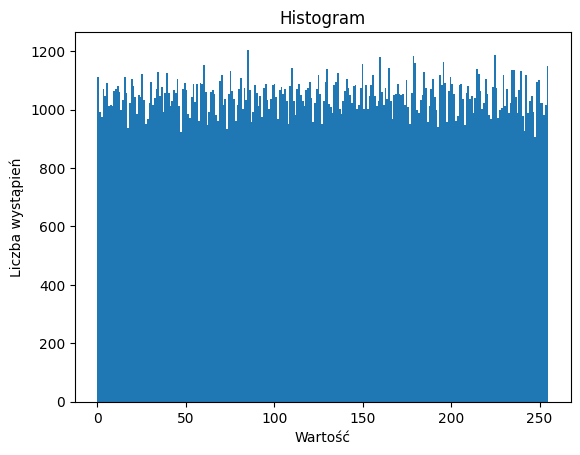

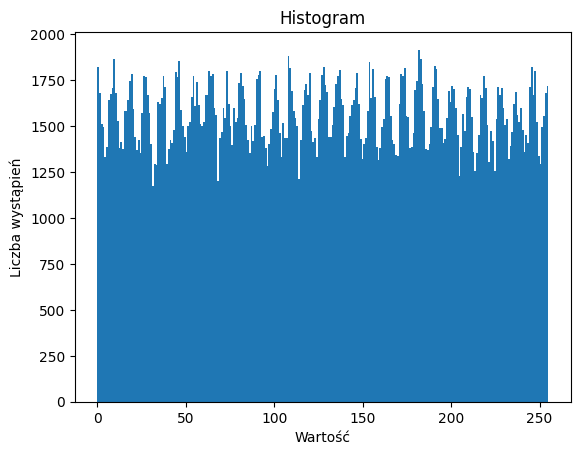

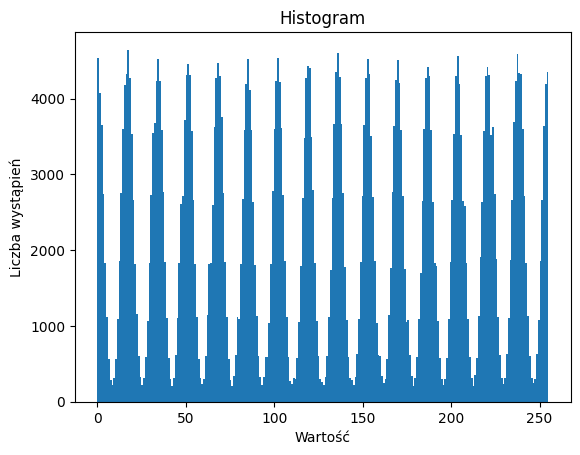

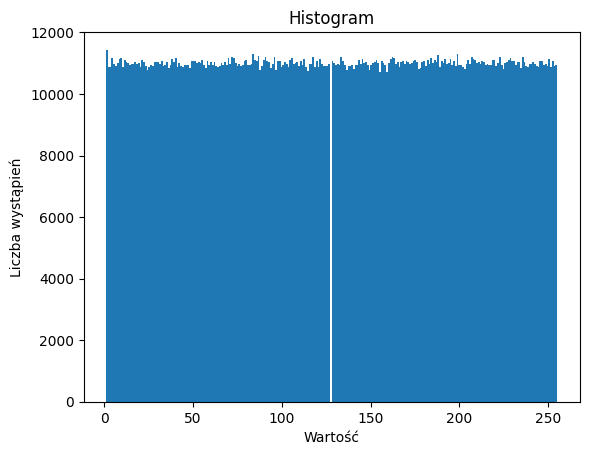

7.99428189705125
2805431


In [4]:
import wave
import matplotlib.pyplot as plt
import struct
import numpy as np


def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = 2 if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

def swap_bits(num):
    # Swap the 32 most significant bits with the 32 least significant bits
    msb = num >> 32
    lsb = num & ((1 << 32) - 1)
    swapped_num = (lsb << 32) | msb
    # Perform XOR operation to increase randomness
    result = swapped_num ^ num
    return result

def hist_input(A, n = 3):
    if n == 2:
        r = []
        mask = 0b00000011
        for v in A:
            r.append(v & mask)
            
        r_new = []
        for i in range(0, len(r), 4):
            byteFromBts = 0
            byteFromBts = r[i] << 6 | r[i+1] << 4 | r[i+2] << 2 | r[i+3]
            r_new.append(byteFromBts)
            
    elif n == 3:
        r = []
        mask = 0b00000111
        for v in A:
            r.append(v & mask)
            
        r24 = []
        for i in range(0, len(r), 8):
            temp = r[i] << 21 | r[i+1] << 18 | r[i+2] << 15 | r[i+3] << 12 | r[i+4] << 9 | r[i+5] << 6 | r[i+6] << 3 | r[i+7]
            r24.append(temp)
            
        r_new = []
        for i in range(len(r24)):
            r_new.append(r24[i] & 0b111111110000000000000000 >> 16)
            r_new.append(r24[i] & 0b000000001111111100000000 >> 8)
            r_new.append(r24[i] & 0b000000000000000011111111)
            
        for x in r_new:
            if x == 0:
                r_new.pop(x)
        
                      
    elif n==4:
        r = []
        mask = 0b00001111
        for v in A:
            r.append(v & mask)
    
        r_new = []
        for i in range(0, len(r), 2):
            byteFromBts = 0
            byteFromBts = r[i] << 4
            byteFromBts = byteFromBts | r[i+1]
            r_new.append(byteFromBts)
    else:
        raise ValueError("n must be in range of [2, 4]")

    # Tworzenie histogramu
    plt.hist(r_new, 256)

    # Tytuł wykresu i etykiety osi
    plt.title("Histogram")
    plt.xlabel("Wartość")
    plt.ylabel("Liczba wystąpień")

    # Wyświetlanie wykresu
    plt.show()
    
    return r



# Open the wave file and read the binary data
w = wave.open("sound-samples/test.wav", "rb")
if w is None:
    print("Error: Unable to open file")
    exit()


nchannels = w.getnchannels()
sample_width = w.getsampwidth()
framerate = w.getframerate()
nframes = w.getnframes()

# Read the audio data as a string of bytes
audio_data = w.readframes(nframes)

# Convert the audio data to a numpy array
audio_data = np.frombuffer(audio_data, dtype=np.uint16)

w.close()

#podajemy parametry
L = 8 #edytujemy L
N = 256000 #edytujemy N
gamma = 2
epsilon = 0.1
alpha = 1
n = int(N / 256 * 8)

A = []
for byte in audio_data:
    A.append(byte)

# check if audio file is long enough
if len(A) < n:
    raise ValueError("Audio file is too short")

hist_input(A, 2)
hist_input(A, 3)
hist_input(A, 4)

r = []
mask = 0b00000111
for v in A:
    r.append(v & mask)

x = [[0.141592, 0.653589, 0.793238, 0.462643, 0.383279, 0.502884, 0.197169, 0.399375]]
c = 0

def fT(x, alpha):
    if 0 <= x < 0.5:
        return alpha * x
    elif 0.5 <= x <= 1:
        return alpha * (1 - x)
    else:
        raise ValueError("x must be in range of [0, 1]")

z = [0,0,0,0,0,0,0,0]
O = []
y = 0

while len(O) <= N:
    for i in range(L):
        t = len(x)-1
        x[t][i] = ((0.071428571 * r[y]) + x[t][i]) * 0.666666667
        c += 1
    for t in range(gamma):
        for i in range(L):
            try:
                x[t+1][i] = (1 - epsilon) * fT(x[t][i], alpha) + epsilon/2 * (fT(x[t][(i+1)%L], alpha)) + fT(x[t][(i-1)%L], alpha)
            except:
                x.append([0,0,0,0,0,0,0,0])
                x[t+1][i] = (1 - epsilon) * fT(x[t][i], alpha) + epsilon/2 * (fT(x[t][(i+1)%L], alpha)) + fT(x[t][(i-1)%L], alpha)
    for i in range(L):
        word = struct.pack('d', x[2][i])
        # Konwersja ciągu bajtów na wartość uint64
        int_value = int.from_bytes(word, byteorder='big', signed=False)
        z[i] = int_value
        x[0][i] = x[2][i]
    for i in range(int(L/2)):
        z[i] = int(z[i]) ^ swap_bits(int(z[i+int(L/2)]))
    O.append(z[0] + z[1]*256 + z[2]*pow(2,16) + z[3]*pow(2,24))
    y+=1

# Pobieranie po 8 bitów z kazdej próbki wyjściowej
bajty_z_O = []
for j in range(len(O)-1):
    for i in range(0, 256, 8):
        bajt = (O[j] >> (256 - (i + 8))) & 0xFF
        if(bajt != 0 ):
            bajty_z_O.append(bajt)

# Tworzenie histogramu
plt.hist(bajty_z_O, 256)

# Tytuł wykresu i etykiety osi
plt.title("Histogram")
plt.xlabel("Wartość")
plt.ylabel("Liczba wystąpień")

# Wyświetlanie wykresu
plt.show()

# Liczenie entropi
e = entropy1(bajty_z_O, base=2)
print(e)

print(len(bajty_z_O))
with open('do_re_mi.txt', 'w') as f:
    f.write(str(bajty_z_O))